In [192]:
import os
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021')
from kalman_gst import *
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021/AdaptiveCircuit')
from pygsti.modelpacks import smq1Q_XYZI as std

In [193]:
def filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update(circ, cvec, clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

In [194]:
from scipy.stats import multinomial

def experimental_loglikelihood(circuit_list, dataset, model):
    """
    multinomial likelihood of observations under the given model 
    
    assumes all the circuits have the same number of qubits
    """
    hdims = 2**circuit_list[0].width
    count_matrix = np.zeros([0, hdims])
    pmat = np.zeros([0, hdims])
    for idx, circ in enumerate(circuit_list):
        count_vec = vector_from_outcomes(dataset[circ].counts, hdims)
        count_matrix = np.vstack([count_matrix, count_vec])
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        pmat = np.vstack([pmat, p_model])
    return sum(multinomial.logpmf(count_matrix, sum(count_matrix[0, :]), pmat))

def max_loglikelihood(circuit_list, dataset):
    """
    max loglikelihood 
    """
    hdims = 2**circuit_list[0].width
    count_matrix = np.zeros([0, hdims])
    pmat = np.zeros([0, hdims])
    for idx, circ in enumerate(circuit_list):
        count_vec = vector_from_outcomes(dataset[circ].counts, hdims)
        count_matrix = np.vstack([count_matrix, count_vec])
        frequency = count_vec/sum(count_vec)
        pmat = np.vstack([pmat, frequency])
    return sum(multinomial.logpmf(count_matrix, sum(count_matrix[0, :]), pmat))

In [195]:
SEED = 2021
NUM_SHOTS = 256
np.random.seed(SEED)

In [196]:
# setup the datagen model
max_fogi_error_rate = 0.1
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [197]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))

Model is CPTP...  True
avg. gate-set infidelity:  0.09240756473428763
mean square error:  0.0771129612974869


In [198]:
# make an edesign and simulate the data
maxLengths = [1,2,4, 8]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, NUM_SHOTS, seed=SEED) #, sample_error='none')

In [199]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  128 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  258 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  531 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  874 circuits ---
Iterative GST Total Time: 2.4s


In [200]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

In [201]:
# run a Kalman filter in the usual way
prior_covar = 0.1*np.eye(target_model.num_params)
usual_post_model, usual_post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[-1], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [00:48<00:00, 17.88it/s]


In [202]:
usual_parameter_history = saved_data[0]
usual_covar_history = saved_data[1]

  0%|                                                                                                                                                                                                              | 0/25 [17:12:14<?, ?it/s]


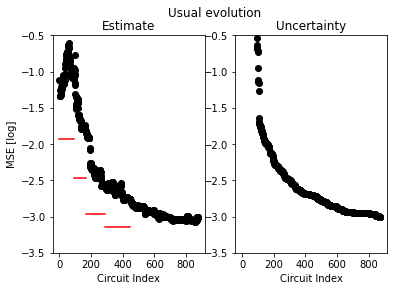

In [203]:
%matplotlib inline
plt_spacing = 1
yrange = [-3.5, -0.5]
make_error_plot('Usual evolution', usual_parameter_history, mdl_datagen.to_vector(), usual_covar_history, yrange, mle_estimates, germ_length_ranges, plt_spacing)

In [209]:
print(len(edesign.circuit_lists[0]))
print(len(edesign.circuit_lists[-1]))

128
874


## finding the best jacobian

The Kalman update for the covariance is
$$ P_\text{post} = (1 - K_k H_k) P_\text{prior} $$
where the Kalman gain is 
$$ K_k = P_\text{prior} H_k^T (H_k P_{\text{prior}} H_k^T + R_k)^{-1} $$

To estimate circuit shot noise, we'll use a pseduo-count vector:
$$ 
    \vec{\alpha} = N \vec{p}_\text{estimate} + \vec{1}
$$
and the covariance
$$
    R_k = \frac{1}{N+d+1} \bigg( \frac{\text{diag}( \vec{\alpha}) }{N+d} - \frac{ \alpha \alpha^T}{(N+d)^2} \bigg)
$$

In order to penalize circuits that are too informative, we will compare $H P H^T$ with the autocovaraince of the predicted observations. That is, we will calculate $u^{(i)} = h_k(x^{(i)})$ for $x^{(i)} \sim \mathcal{N}(\hat{x}, P)$, then calculate $\bar{u}$ and finally
$$
    C = \frac{1}{N} \sum_{i=1}^N (u^{(i)} - \bar{u})(u^{(i)} - \bar{u})^T
$$

A metric like the trace of $H P H^R - C$ then gives a measure of the quality of the covariance apporximation. The hypothesis is that this is small for circuits that are useful in determining the true $x$. 

In [210]:
mdl_datagen.probabilities((edesign.circuit_lists[0])[0])

OutcomeLabelDict([(('0',), 0.9086089807426871), (('1',), 0.09139101925731291)])

In [213]:
def estimate_model_prediction_error(model, model_covar, circuit, num_model_samples):
    fiducial_model = model.copy()
    predictions = []
    num_params = model.num_params
    xmodel = model.to_vector()
    mean_prediction = vector_from_outcomes(model.probabilities(circuit), 2**circuit.width)
    for n in range(num_model_samples):
        xsample = np.random.multivariate_normal(np.zeros(num_params), model_covar)
        fiducial_model.from_vector(xmodel + xsample)
        predictions.append( vector_from_outcomes(fiducial_model.probabilities(circuit), 2**circuit.width) )    
    shifted_predictions = [p - mean_prediction for p in predictions]
    
    covar_out = np.zeros((2**circuit.width, 2**circuit.width))
    for p in shifted_predictions:
        covar_out += (1/num_model_samples)*np.outer(p, p)
    return covar_out

## test for model observation error 

If the linear approximation holds for the current circuit under the given model uncertainty, then for r.v's defined $u^{(i)} = h(x^{(i)}) - h(\bar{x})$ where $x^{(i)} \sim \mathcal{N}(\bar{x}, P)$, we have that
$$
    \frac{1}{N} \sum_{i=1}^N u^{(i)} (u^{(i)})^T \rightarrow H P H^T
$$

So we can test the linear approximation by calculating 
$$
    \sum_{i = 1}^N u^{(i)} (H P H^T)^{-1} (u^{(i)})^T 
$$
which will be $\chi^2_{d\times N}$ distributed under the null hypothesis that the linear approximation holds, where $d$ is the dimension of the Hilbert space

In [233]:
def test_linear_approx(model, model_covar, circuit, num_model_samples):
    # first construct the mean shifted predictions
    fiducial_model = model.copy()
    predictions = []
    num_params = model.num_params
    xmodel = model.to_vector()
    mean_prediction = vector_from_outcomes(model.probabilities(circuit), 2**circuit.width)
    for n in range(num_model_samples):
        xsample = np.random.multivariate_normal(np.zeros(num_params), model_covar)
        fiducial_model.from_vector(xmodel + xsample)
        predictions.append( vector_from_outcomes(fiducial_model.probabilities(circuit), 2**circuit.width) )    
    shifted_predictions = [p - mean_prediction for p in predictions]
    
    # then calculate H P H^T
    H = matrix_from_jacob( model.sim.dprobs(circuit), 2**circuit.width)
    HPH = H@model_covar@H.T
    HPHinv = np.linalg.pinv(HPH)
    
    test_stat = 0
    for u in shifted_predictions:
        test_stat += u@HPHinv@u.T
    return test_stat

In [265]:
circ = (edesign.circuit_lists[0])[-1]
model = mdl_datagen
P = 0.005*np.eye(model.num_params)

print(test_linear_approx(model, P, circ, 1000))

H = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
print(H@P@H.T)


6983.298401405331
[[ 0.04370583 -0.04370583]
 [-0.04370583  0.04370583]]


## test for non-linear observation error 

If the linear approximation holds for the current circuit under the given model uncertainty, then for r.v's defined $u^{(i)} = h(x^{(i)}) - h(\bar{x})$ for $x^{(i)} \sim \mathcal{N}(\bar{x}, P)$, then 
$$
    \sum_{i = 1}^N |u^{(i)} - H(x - \bar{x})|^2 
$$
will be small

In [317]:
def avg_nonlinear_model_error(model, model_covar, circuit, num_model_samples):
    fiducial_model = model.copy()
    num_params = model.num_params
    xmodel = model.to_vector()
    mean_prediction = vector_from_outcomes(model.probabilities(circuit), 2**circuit.width)
    H = matrix_from_jacob( model.sim.dprobs(circuit), 2**circuit.width)
    nonlinear_error = 0
    for n in range(num_model_samples):
        xsample = np.random.multivariate_normal(np.zeros(num_params), model_covar)
        fiducial_model.from_vector(xmodel + xsample)
        prediction = vector_from_outcomes(fiducial_model.probabilities(circuit), 2**circuit.width)
        shifted_prediction = prediction - mean_prediction
        nonlinear_error += np.linalg.norm(shifted_prediction - H@xsample)
    return nonlinear_error/num_model_samples

In [328]:
circ = (edesign.circuit_lists[-1])[-1]
model = mdl_datagen
P = 0.001*np.eye(model.num_params)

print(avg_nonlinear_model_error(model, P, circ, 100))

0.03412590896515246


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:22<00:00,  1.27s/it]


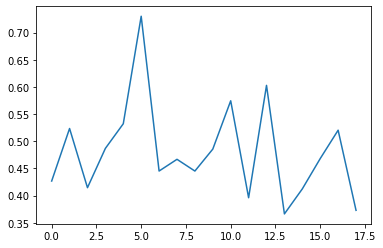

In [334]:
P = 0.01*np.eye(model.num_params)
model = mdl_datagen
nonlin_errors = []
circ_list = edesign.circuit_lists[-1]
for i in tqdm(range(1, len(circ_list), 50)):
    nonlin_errors.append(avg_nonlinear_model_error(model, P, circ, 250))
plt.plot(nonlin_errors)

In [208]:
# look at this after running a few circuits

prior_covar = 0.1*np.eye(target_model.num_params)
post_model, post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[0], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 26.42it/s]


In [96]:
print(np.trace(prior_covar))
print(np.trace(post_covar))
print(np.trace(post_covar)/post_covar.shape[0])

2.4000000000000004
0.014118383525663053
0.0005882659802359606


0
[[ 0.00027793 -0.00027793]
 [-0.00027793  0.00027793]]
[[ 0.00021757 -0.00021757]
 [-0.00021757  0.00021757]]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [07:58<00:00,  1.83it/s]


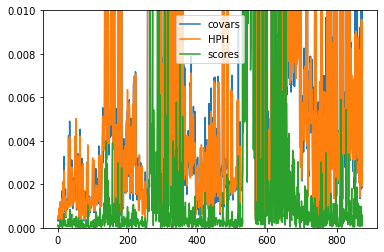

In [131]:
circ = (edesign.circuit_lists[-1])[0]
model = target_model
P = post_covar
print(len(circ))

covar_predict = estimate_model_prediction_error(model, P, circ, 100)
print(covar_predict)

H = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
print(H@P@H.T)

circ_list = edesign.circuit_lists[-1]
scores = []
covars = []
HPHs = []
for i in tqdm(range(0, len(circ_list), 1)):
    circ = circ_list[i]
    H = matrix_from_jacob(model.sim.dprobs(circ), 2)
    covar_predict = estimate_model_prediction_error(model, P, circ, 100)
    covars.append(covar_predict)
    HPH = H@P@H.T
    HPHs.append(HPH)
    scores.append(np.linalg.norm(covar_predict - H@P@H.T))
plt.plot([np.trace(c) for c in covars], label='covars')
plt.plot([np.trace(c) for c in HPHs], label='HPH')
plt.plot(scores, label='scores')
plt.ylim([0, 0.01])
plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:52<00:00,  1.67it/s]


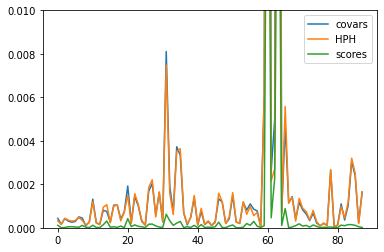

In [134]:
circ = (edesign.circuit_lists[-1])[0]
model = post_model
circ_list = edesign.circuit_lists[-1]
scores = []
covars = []
HPHs = []
for i in tqdm(range(0, len(circ_list), 10)):
    circ = circ_list[i]
    H = matrix_from_jacob(model.sim.dprobs(circ), 2)
    covar_predict = estimate_model_prediction_error(model, P, circ, 100)
    covars.append(covar_predict)
    HPH = H@P@H.T
    HPHs.append(HPH)
    scores.append(np.linalg.norm(covar_predict - H@P@H.T))
plt.plot([np.trace(c) for c in covars], label='covars')
plt.plot([np.trace(c) for c in HPHs], label='HPH')
plt.plot(scores, label='scores')
plt.ylim([0, 0.01])
plt.legend()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 88/88 [00:52<00:00,  1.69it/s]


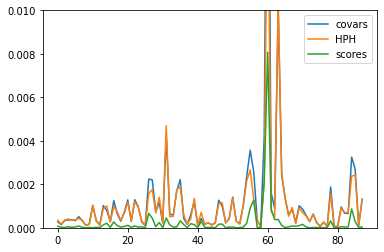

In [133]:
circ = (edesign.circuit_lists[-1])[0]
model = mdl_datagen
circ_list = edesign.circuit_lists[-1]
scores = []
covars = []
HPHs = []
for i in tqdm(range(0, len(circ_list), 10)):
    circ = circ_list[i]
    H = matrix_from_jacob(model.sim.dprobs(circ), 2)
    covar_predict = estimate_model_prediction_error(model, P, circ, 100)
    covars.append(covar_predict)
    HPH = H@P@H.T
    HPHs.append(HPH)
    scores.append(np.linalg.norm(covar_predict - H@P@H.T))
plt.plot([np.trace(c) for c in covars], label='covars')
plt.plot([np.trace(c) for c in HPHs], label='HPH')
plt.plot(scores, label='scores')
plt.ylim([0, 0.01])
plt.legend()

In [109]:
(edesign.circuit_lists[-1])[-1]

Circuit(Gypi2:0Gypi2:0Gypi2:0(Gxpi2:0Gypi2:0Gzpi2:0)^2Gypi2:0Gypi2:0Gypi2:0@(0))

In [161]:
# plot some histograms of circuit predictions for fixed circuits, models, and model uncertainties

circ_indices = [0, 10, 100, 500, -1]
circ_list = edesign.circuit_lists[-1]
model = mdl_datagen
covar = post_covar
num_samples = 256

fid_model = model.copy()

pdists = dict()
for k in tqdm(circ_indices):
    circ = circ_list[k]
    p0s = []
    for n in range(num_samples):
        xsample = np.random.multivariate_normal(np.zeros(model.num_params), covar)
        fid_model.from_vector(fid_model.to_vector() + xsample)
        p_model = vector_from_outcomes(fid_model.probabilities(circ), 2)
        p0 = p_model[0]
        p0s.append(p0)
    pdists[k] = p0s

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


(array([12., 67., 44., 29., 36., 25., 13., 18., 10.,  2.]),
 array([0.4984965 , 0.49923691, 0.49997731, 0.50071771, 0.50145811,
        0.50219851, 0.50293892, 0.50367932, 0.50441972, 0.50516012,
        0.50590052]),
 <BarContainer object of 10 artists>)

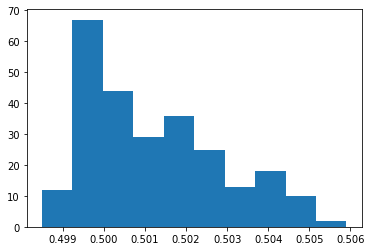

In [163]:
plt.hist(pdists[-1])

In [164]:
def find_best_circuit(circ_list, model, covar, num_shots):
    """
    The simpliest function to find the best next circuit
        
    We estimate the observation noise for each circuit using the filter's prediction
    
    The algo is to go through each circuit and assign a score per:
        1) estimate the sampling noise
        2) calculate the model jacobian
        3) calculate the kgain
        4) assign a score per the trace* of (1-KH)P
    Pick the smallest score
    """
    
    traces = dict()
    for circ in circ_list:
        hdims = 2**circ.width
        # simulate circuit probs
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        # estimate sampling covar
        pseudo_counts = num_shots*p_model + np.ones(hdims)
        sampling_covar = (1/(num_shots + hdims + 1)) * (
            np.diag(pseudo_counts)/(num_shots + hdims) + 
            np.outer(pseudo_counts, pseudo_counts)/(num_shots + hdims)**2
        )
        # calculate kgain
        jac = matrix_from_jacob(model.sim.dprobs(circ), hdims) 
        kgain = covar@jac.T@np.linalg.pinv(jac@covar@jac.T + sampling_covar)
        # find the resulting posterior covariance
        post_covar = (np.eye(covar.shape[0]) - kgain@jac)@covar
        traces[circ] = np.trace(post_covar)
    min_trace_val = min(traces.values())
    best_circuits = [key for key in traces if traces[key] == min_trace_val]
    return best_circuits[0], traces

In [189]:
def fast_find_best_circuit(circ_list, jdict, hdict, model, covar, num_shots):
    """
    The simpliest function to find the best next circuit
        
    We estimate the observation noise for each circuit using the filter's prediction
    
    The algo is to go through each circuit and assign a score per:
        1) estimate the sampling noise
        2) calculate the model jacobian
        3) calculate the kgain
        4) assign a score per the trace* of (1-KH)P
    Pick the smallest score
    """
    
    traces = dict()
    for circ in circ_list:
        hdims = 2**circ.width
        # simulate circuit probs
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        # estimate sampling covar
        pseudo_counts = num_shots*p_model + np.ones(hdims)
        sampling_covar = (1/(num_shots + hdims + 1)) * (
            np.diag(pseudo_counts)/(num_shots + hdims) + 
            np.outer(pseudo_counts, pseudo_counts)/(num_shots + hdims)**2
        )
        # calculate kgain
        try:
            jac = jdict[circ] + hdict[circ]@model.to_vector()
        except:
            print(f'circ {circ} not in the dictionaries')
            jac = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
        kgain = covar@jac.T@np.linalg.pinv(jac@covar@jac.T + sampling_covar)
        # find the resulting posterior covariance
        post_covar = (np.eye(covar.shape[0]) - kgain@jac)@covar
        traces[circ] = np.trace(post_covar)
    min_trace_val = min(traces.values())
    best_circuits = [key for key in traces if traces[key] == min_trace_val]
    return best_circuits[0], traces

In [94]:
pbar.close()

  0%|                                                                                                                                                                                                                 | 0/25 [31:46<?, ?it/s]


In [164]:
def load_dict(filename):
    with open(filename + '.pickle', 'rb') as f:
        return pickle.load(f)

In [187]:
hdicts = load_dict('IXYZ_hess')
jdicts = load_dict('IXYZ_jacs')
jdict = dict()
for j in jdicts:
    jdict.update(j)
hdict = dict()
for h in hdicts:
    hdict.update(h)

In [191]:
%matplotlib inline
# try it out starting from a gaussian at the target
num_updates = 25
show_output = True

circ_list = edesign.circuit_lists[1] # just do length 1 and 2 germs for this example

covar = 0.01*np.eye(target_model.num_params)
ekf = ExtendedKalmanFilter(target_model, covar)

adaptive_parameter_history = []
adaptive_covar_history = []

pbar = tqdm(total=num_updates)


current_update = 0
while(current_update < num_updates):
    circ, traces = fast_find_best_circuit(circ_list, jdict, hdict, ekf.model, ekf.P, NUM_SHOTS)
    if show_output:
        print('MSE: ', mserror(ekf.model, mdl_datagen))
        print('Best circ: ', circ)
        print('Predicted covar: ', traces[circ])

        plt.plot([v for v in traces.values()])
        plt.show()
    else:
        # show progress if not output
        pbar.update(1)
        
    cvec = vector_from_outcomes(dataset[circ].counts, 2**circ.width)
    ekf.update(circ, cvec)
    adaptive_parameter_history.append(ekf.model.to_vector())
    adaptive_covar_history.append(ekf.P)    
    
    current_update += 1
pbar.close()



  0%|                                                                                                                                                                                                                 | 0/25 [03:34<?, ?it/s]


circ Qubit 0 -----
 not in the dictionaries
circ Qubit 0 ---|Gxpi2|---
 not in the dictionaries
circ Qubit 0 ---|Gypi2|---
 not in the dictionaries
circ Qubit 0 ---|Gxpi2|-|Gxpi2|---
 not in the dictionaries
circ Qubit 0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|---
 not in the dictionaries
circ Qubit 0 ---|Gypi2|-|Gypi2|-|Gypi2|---
 not in the dictionaries
circ Qubit 0 ---|Gxpi2|-|Gypi2|---
 not in the dictionaries
circ Qubit 0 ---|Gxpi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---
 not in the dictionaries
circ Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gypi2|---
 not in the dictionaries
circ Qubit 0 ---|Gypi2|-|Gxpi2|---
 not in the dictionaries
circ Qubit 0 ---|Gypi2|-|Gypi2|---
 not in the dictionaries
circ Qubit 0 ---|Gypi2|-|Gxpi2|-|Gxpi2|---
 not in the dictionaries
circ Qubit 0 ---|Gypi2|-|Gxpi2|-|Gxpi2|-|Gxpi2|---
 not in the dictionaries
circ Qubit 0 ---|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|---
 not in the dictionaries
circ Qubit 0 ---|Gxpi2|-|Gxpi2|-|Gypi2|---
 not in the dictionaries
circ Qubit 0 ---|Gxpi2|-|Gxpi2|-|Gxp


KeyboardInterrupt



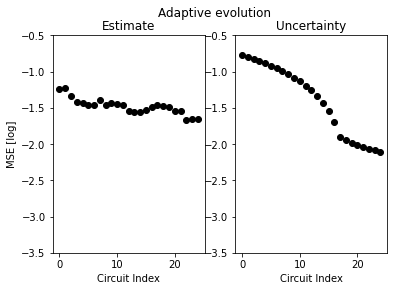

In [18]:
yrange = [-3.5, -0.5]
make_error_plot('Adaptive evolution', adaptive_parameter_history, mdl_datagen.to_vector(), adaptive_covar_history, yrange, None, germ_length_ranges, 1)

In [30]:
print('mse of target with datagen', np.log10(mserror(target_model, mdl_datagen)))
print('mse of final mle with datagen', np.log10(mserror(mdl_datagen, mle_estimates[-1])))
print('mse of adaptive filter estimate with datagen', np.log10(mserror(ekf.model, mdl_datagen)))

mse of target with datagen -1.4293414708712984
mse of final mle with datagen -3.299098379531565
mse of adaptive filter estimate with datagen -1.4293414708712984


# Warm starting it

In [165]:
# try warm starting by running all germ length 1 circuits then doing adaptive filtering
# run a Kalman filter in the usual way on all germ length 1 circuits
prior_covar = 0.1*np.eye(target_model.num_params)
germ1_model, germ1_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[0], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:04<00:00, 25.86it/s]


In [167]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

In [170]:
def fx(x, dt):
    return x

def model_wrapper(x_state, circ, model):
    model.from_vector(x_state)
    return vector_from_outcomes(model.probabilities(circ), 2**circ.width)

dt = 1
points = MerweScaledSigmaPoints(germ1_model.num_params, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(germ1_model.num_params, 2, dt=0, hx=model_wrapper, fx=fx, points=points)
ukf.Q = 1e-9*np.eye(germ1_model.num_params)
R_add = 1e-9*np.eye(2)
ukf_filter_model = germ1_model.copy()

ukf.x = germ1_model.to_vector()
ukf.P = germ1_covar


  0%|                                                                                                                                                                                                                 | 0/10 [01:35<?, ?it/s]


MSE:  0.022066186796729295
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted covar:  0.011996416185385782


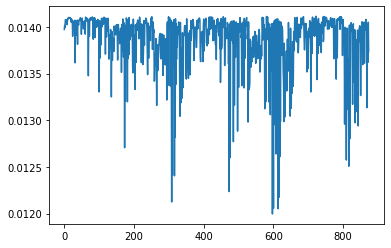

MSE:  0.022066186796729295
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted covar:  0.011996416185385782


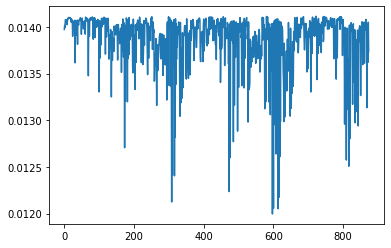

MSE:  0.022066186796729295
Best circ:  Qubit 0 ---|Gxpi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gypi2|-|Gxpi2|---

Predicted covar:  0.011996416185385782


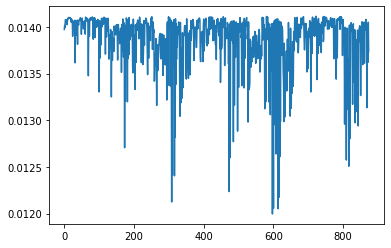


KeyboardInterrupt



In [172]:
# now swtich to adaptive filtering with sigma-point updates
num_updates = 10
show_output = True

circ_list = edesign.circuit_lists[-1] # now all the circuits in the maxlength exp
fid_model = target_model.copy()

adaptive_parameter_history = []
adaptive_covar_history = []

pbar = tqdm(total=num_updates)

current_update = 0
while(current_update < num_updates):
    fid_model.from_vector(ukf.x)
    circ, traces = find_best_circuit(circ_list, fid_model, ukf.P, NUM_SHOTS)
    if show_output:
        print('MSE: ', mserror(ekf.model, mdl_datagen))
        print('Best circ: ', circ)
        print('Predicted covar: ', traces[circ])

        plt.plot([v for v in traces.values()])
        plt.show()
    else:
        # show progress if not output
        pbar.update(1)
        
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = (cvec+np.ones(len(cvec)))/(sum(cvec) + len(cvec))
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior
    
    R_obs = categorical_covar(freq)/sum(cvec)
    ukf.predict()
    ukf.update(freq, R=R_obs+R_add, circ=circ, model=ukf_filter_model)
    adaptive_parameter_history.append(ukf.x)
    adaptive_covar_history.append(ukf.P)    
    
    current_update += 1
pbar.close()

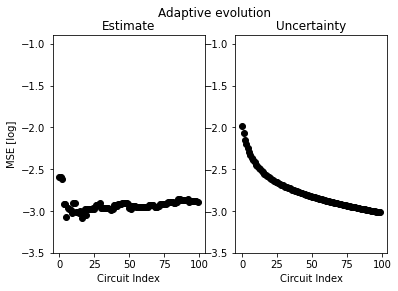

In [120]:
yrange = [-3.5, -0.9]
make_error_plot('Adaptive evolution', adaptive_parameter_history, mdl_datagen.to_vector(), adaptive_covar_history, yrange, None, germ_length_ranges, 1)